# CNN autoencoder and Clustering from MTRX data

Use this notebook to load Scienta Omicron Matrix format SPM data and create standardised images for machine learning training and analysis. The code can generate both JPG image data, useful for manually checking the data, and windowed numpy data that can be loaded into ML models. 

The notebook then creates an autoencoder for training on a large dataset, followed by KMEANS clustering. 

**Author**: Steven R. Schofield  
**Created**: November, 2024

In [1]:
# Define path where to find the module. This allows for a different path depending on where the code is running (my mac or the cluster)
import os

module_path_list = [
    '/Users/steven/academic-iCloud/Python/modules',
    '/hpc/srs/Python/modules'
] 

data_path_list = [
    '/Users/steven/Python-data'
]

module_path = next((p for p in module_path_list if os.path.exists(p)), None)
if not module_path:
    exit("No valid module paths.")
else:
    print('module_path = {}'.format(module_path))

data_path = next((p for p in data_path_list if os.path.exists(p)), None)
if not module_path:
    exit("No valid data paths.")
else:
    print('data_path = {}'.format(data_path))

# adjust tensorflow output level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 0 default all messages, 1 warnings and errors, 2, errors, 3 fatal errors only

module_path = /Users/steven/academic-iCloud/Python/modules
data_path = /Users/steven/Python-data


In [2]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import os, sys
import numpy as np

import platform

from datetime import datetime

# Add custom module path to list
sys.path.append(module_path)

# Import custom module
import SRSML24.data_prep as dp
import SRSML24.model as m

import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

#import platform 

m.print_system_info()

start_time = dp.current_datetime()


Python version: 3.8.18 (default, Sep 11 2023, 08:17:16) 
[Clang 14.0.6 ]
TensorFlow version: 2.13.0
TensorFlow is built with CUDA: False
TensorFlow is built with ROCm: False

System: Darwin 24.1.0 (arm64)
Platform: macOS-15.1.1-arm64-arm-64bit
Processor: arm

Number of GPUs available to TensorFlow: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

>>> Running with GPU available <<<  (macOS-15.1.1-arm64-arm-64bit)

Current time 2024-12-03 14:23:42


In [21]:
# Parameters for windows creation
job_name = 'all_data_2023'
job_data_path = dp.create_new_data_path(data_path, job_name, include_date=False)
mtrx_train_path = os.path.join(data_path, 'mtrx/train')
mtrx_test_path = os.path.join(data_path, 'mtrx/test')
mtrx_predict_path = os.path.join(data_path, 'mtrx/predict')
flatten_method = 'poly_xy'
pixel_density = 15.0    # Convert all images to a constant pixel density
pixel_ratio = 0.7       # If an image has less than this % in the slow scan direction it is discarded
data_scaling = 1.e9     # Scale the z-height of the data
window_size = 32        # Window size for training/validation
window_pitch = 32       # Window pitch for training/validation
together = True        # Set this True to save image windows for a mtrx image as a single file rather than separate files.
collate = False         # Set this True to remove all subfolder directories and save all data in root data path

# Parameters for training
model_name = 'unet_' + job_name
batch_size = 128
buffer_size = 12800 # shuffling
learning_rate = 1e-4
epochs = 5

# Parameters for clustering
cluster_model_name = model_name + '_kmeans'
cluster_batch_size = 5120 # This is the number of latent features in a batch for clustering. 
                          # Does not have to be the same as for training and probably should 
                          # be larger. 
cluster_buffer_size = cluster_batch_size * 5    # shuffling buffer
num_clusters=20                                # Desired number of clusters (centroids) to form in the data.
n_init=50                                       # Number of times the algorithm will run with different centroid seeds.
max_iter=1000                                   # Maximum iterations allowed for each mini-batch to refine centroids.
reassignment_ratio=0.05                         # Fraction of clusters reassigned per step; lower values stabilize updates.


# Parameters for PREDICTIONS
predict_window_pitch = 4               # Window pitch for prediction


# DATA LIMITS FOR TESTING THE CODE
mtrx_train_data_limit = 500         # Number of MTRX files to process (training)
mtrx_test_data_limit = 100         # Number of MTRX files to process (validation)

train_data_limit = None #2000*batch_size
predict_data_limit = None

In [4]:
# REMOVE ALL DATA FOLDERS EXCEPT MTRX 
dp.delete_data_folders(job_data_path, override=True)

Deleted: /Users/steven/Python-data/all_data_2023/windows
All specified folders have been successfully deleted.


In [5]:
# Training data
mtrx_train_file_list, _ = dp.list_files_by_extension(mtrx_train_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_train_file_list[0:mtrx_train_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = True,
    save_jpg = False,
    together = together,
    collate = collate,
    verbose = False
    )

# Test data
mtrx_test_file_list, _ = dp.list_files_by_extension(mtrx_test_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_test_file_list[0:mtrx_test_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = True,
    save_jpg = False,
    together = together,
    collate = collate,
    verbose = False
    )

Found 65110 files with extension 'Z_mtrx' in directory:
/Users/steven/Python-data/mtrx/train
There are 500 files to process
....t...t....t....................t.t............ttt.......t.......t.....ttt.t............tt..tttt. 100
t........t......ttt..t..tt.ttt.........t..t....tt.t.tt..tt...tttttttttttttttttttttt.ttt.ttt.tt..ttt 200
tt..t..tttt...tt.tttt.t.t.tttttttt.t.tt.tt.t..t.tt..t.......t.t....ttt...........ttt........t...t... 300
t....t.............t...............tt..................t........t......ttt.ttt...t....t..t.t....t.t 400
........tttttttttttttt...tttttttttttt........t........ttttttt....tttt.tt.......ttttt.t............. 500

********************
Conversion complete.
********************

Found 2560 files with extension 'Z_mtrx' in directory:
/Users/steven/Python-data/mtrx/test
There are 100 files to process
t....t..t.....tt..........................t..............t...t....t.t.....t....................t..t 100

********************
Conversion complete.
********************

# Set up tensorflow data pipeline

In [6]:
# Training data - tensorflow data pipeline for autoencoder
windows_train_path = os.path.join(job_data_path, 'windows/train')
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]
# Create dataset with prefetching
#train_dataset = m.create_tf_dataset(train_files, batch_size=batch_size, buffer_size=buffer_size, is_autoencoder=True, shuffle=True)
train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

Found 530 files with extension 'npy' in directory:
/Users/steven/Python-data/all_data_2023/windows/train
Data pipeline created with 530 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)



In [7]:
# Validation data - tensorflow data pipeline for autoencoder
windows_test_path = os.path.join(job_data_path, 'windows/test')
test_files, num_test = dp.list_files_by_extension(windows_test_path, 'npy')
test_files = test_files[:train_data_limit]

# Create dataset with prefetching
test_dataset = m.create_tf_dataset_batched(
    test_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

Found 22 files with extension 'npy' in directory:
/Users/steven/Python-data/all_data_2023/windows/test
Data pipeline created with 22 files, batch size: 128, window size: 32
Sample batch shape: (128, 32, 32, 1)



# Autoencoder build and train

In [8]:
# Build and compile the UNET model
autoencoder_model = m.build_autoencoder(window_size=window_size,model_name=model_name)
autoencoder_model.summary()

# Check if running on Apple Silicon
is_mac_silicon = platform.system() == "Darwin" and platform.processor() == "arm"

if is_mac_silicon:
    print("Running on Mac with Apple Silicon. Using legacy RMSprop optimizer.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )
else:
    print("Not running on Mac with Apple Silicon. Using new RMSprop optimizer.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )


Model: "unet_all_data_2023"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_windows (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 Convolutional_1 (Conv2D)    (None, 32, 32, 32)           320       ['Input_windows[0][0]']       
                                                                                                  
 Dropout_1 (Dropout)         (None, 32, 32, 32)           0         ['Convolutional_1[0][0]']     
                                                                                                  
 MaxPooling_1 (MaxPooling2D  (None, 16, 16, 32)           0         ['Dropout_1[0][0]']           
 )                                                                               

In [9]:
# Train the model using the tf.data datasets
history = autoencoder_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1
)

# Save the model as soon as training completes
model_path = os.path.join(job_data_path,'model')
m.save_model(autoencoder_model, model_path, model_name=model_name)

end_time = dp.current_datetime()
dp.elapsed_time(start_time,end_time)

Epoch 1/5
858/858 [==============================] - 85s 98ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0729 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0406
Epoch 2/5
858/858 [==============================] - 84s 98ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0294 - val_loss: 1.7978e-04 - val_mse: 1.7978e-04 - val_mae: 0.0101
Epoch 3/5
858/858 [==============================] - 90s 105ms/step - loss: 5.7703e-04 - mse: 5.7703e-04 - mae: 0.0203 - val_loss: 1.1462e-04 - val_mse: 1.1462e-04 - val_mae: 0.0077
Epoch 4/5
858/858 [==============================] - 90s 104ms/step - loss: 3.4449e-04 - mse: 3.4449e-04 - mae: 0.0157 - val_loss: 9.7981e-05 - val_mse: 9.7981e-05 - val_mae: 0.0068
Epoch 5/5
858/858 [==============================] - 90s 104ms/step - loss: 2.2645e-04 - mse: 2.2645e-04 - mae: 0.0127 - val_loss: 1.7256e-04 - val_mse: 1.7256e-04 - val_mae: 0.0107
Model saved at: /Users/steven/Python-data/all_data_2023/model/unet_all_data_2023.keras
Current time 2024-12-03 14:33

Plot saved to /Users/steven/Python-data/all_data_2023/model/history.jpg


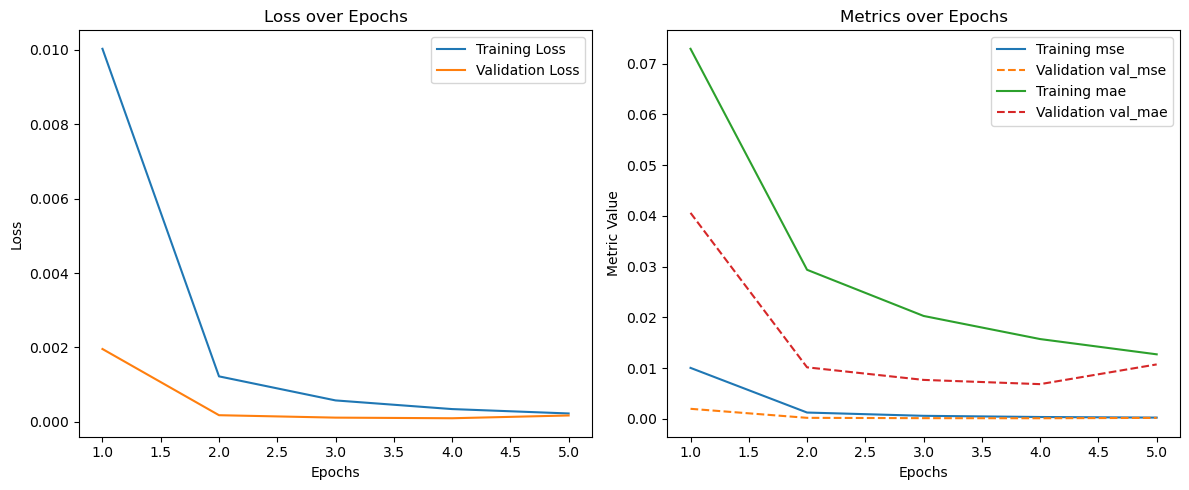

In [10]:
# Plot training history
m.plot_training_history(history, 
                        loss_name='loss', 
                        val_loss_name='val_loss', 
                        metric_names=['mse', 'mae'], 
                        save_to_disk=True,
                        val_metric_names=['val_mse', 'val_mae'],
                        output_path=model_path,
                        dpi=150)

# Extract latent features using autoencoder model
Will save the latent features also to disk so this step needs to run only once for a given set of parameters

In [11]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories='latent_features',
    override=True)

Deleted: /Users/steven/Python-data/all_data_2023/latent_features
All specified folders have been successfully deleted.


In [12]:
# Training data - tensorflow data pipeline 
windows_train_path = os.path.join(job_data_path, 'windows/train')
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=cluster_batch_size, 
    buffer_size=cluster_buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

Found 530 files with extension 'npy' in directory:
/Users/steven/Python-data/all_data_2023/windows/train
Data pipeline created with 530 files, batch size: 5120, window size: 32
Sample batch shape: (5120, 32, 32, 1)



In [13]:
# Load the trained autoencoder model
model_path = os.path.join(job_data_path,'model')
autoencoder_model = m.load_model(model_path, model_name=model_name)

Model loaded from: /Users/steven/Python-data/all_data_2023/model/unet_all_data_2023.keras


In [14]:
# Path to save latent features to disk
latent_features_path = os.path.join(job_data_path, 'latent_features')

m.extract_latent_features_to_disk_from_prebatched_windows(
    autoencoder_model, 
    train_dataset, 
    latent_features_path, 
    features_name='latent_features_train',
    return_array=False,
    verbose=False)

......................
All latent features have been saved to /Users/steven/Python-data/all_data_2023/latent_features.
Sample batch shape: (5120, 4096)


# Create tensorflow dataset pipeline for latent features

In [15]:
# List and sort latent feature files
latent_features_path = os.path.join(job_data_path, 'latent_features')
latent_features_files, num_latent_files = dp.list_files_by_extension(latent_features_path, 'npy')

Found 22 files with extension 'npy' in directory:
/Users/steven/Python-data/all_data_2023/latent_features


In [16]:
# Load the latent features from disk into a tensor dataset pipeline
latent_features_dataset = m.create_latent_features_tf_dataset(
    latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)

Data pipeline created with 22 files, batch size: 5120
Shuffling enabled with buffer size: 25600
Batch shape: (5120, 4096)


# Train KMEANS cluster model

In [22]:
cluster_model, convergence_history = m.train_kmeans(
    latent_features_dataset,                # tf.data.Dataset containing batches of latent feature vectors.
    batch_size=cluster_batch_size,          # Size of each batch for the KMeans model (controls memory usage and stability).
    num_clusters=num_clusters,              # Desired number of clusters (centroids) to form in the data.
    n_init=n_init,                          # Number of times the algorithm will run with different centroid seeds.
    max_iter=max_iter,                      # Maximum iterations allowed for each mini-batch to refine centroids.
    reassignment_ratio=reassignment_ratio   # Fraction of clusters reassigned per step; lower values stabilize updates.
)

# Save cluster model
cluster_model_path = os.path.join(job_data_path,'cluster_model')
m.save_cluster_model(cluster_model, cluster_model_path, model_name=cluster_model_name)

/opt/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1930: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=50.
  super()._check_params_vs_input(X, default_n_init=3)


Batch 1 processed. Inertia: 3101.53515625
Batch 2 processed. Inertia: 3150.826171875
Batch 3 processed. Inertia: 3182.129638671875
Batch 4 processed. Inertia: 3068.46435546875
Batch 5 processed. Inertia: 3190.25244140625
Batch 6 processed. Inertia: 3165.68017578125
Batch 7 processed. Inertia: 3182.36083984375
Batch 8 processed. Inertia: 3055.890869140625
Batch 9 processed. Inertia: 3057.045654296875
Batch 10 processed. Inertia: 3071.1494140625
Batch 11 processed. Inertia: 3166.72607421875
Batch 12 processed. Inertia: 3059.41162109375
Batch 13 processed. Inertia: 3080.91162109375
Batch 14 processed. Inertia: 3112.72119140625
Batch 15 processed. Inertia: 3072.51953125
Batch 16 processed. Inertia: 3094.599609375
Batch 17 processed. Inertia: 3080.50830078125
Batch 18 processed. Inertia: 3124.569580078125
Batch 19 processed. Inertia: 3105.582763671875
Batch 20 processed. Inertia: 3026.948974609375
Batch 21 processed. Inertia: 3121.87353515625
Batch 22 processed. Inertia: 1320.10546875
Final

# Process Predictions MTRX data

In [23]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories='jpg',
    override=True)

No target folders found to delete.


In [24]:
# Prediction data
mtrx_predict_file_list, _ = dp.list_files_by_extension(mtrx_predict_path,'Z_mtrx',verbose=False)

data_scaling = 1.e9     # Scale the z-height of the data

flatten_method = 'row_and_poly_xy_deg_2'
flatten_method = 'row_mean'
flatten_method = 'iterate_mask'
flatten_method = 'poly_xy'

dp.process_mtrx_files(
    mtrx_predict_file_list,
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = predict_window_pitch,
    save_windows = True,
    save_jpg = True,
    collate = False,
    verbose = False
    )

Found 7 files with extension 'Z_mtrx' in directory:
/Users/steven/Python-data/mtrx/predict
There are 7 files to process
iiiiiii
********************
Conversion complete.
********************



# Make data predictions

In [25]:
# Load the trained autoencoder
model_path = os.path.join(job_data_path,'model')
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
cluster_model_path = os.path.join(job_data_path,'cluster_model')
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

Model loaded from: /Users/steven/Python-data/all_data_2023/model/unet_all_data_2023.keras
Cluster model loaded from: /Users/steven/Python-data/all_data_2023/cluster_model/unet_all_data_2023_kmeans.pkl


In [26]:
# Get list of folders containing predict window data
windows_predict_path = os.path.join(job_data_path, 'windows/predict')
predict_data_files_list = dp. find_bottom_layer_folders(windows_predict_path)
predict_data_files_list = predict_data_files_list[:predict_data_limit]

In [27]:
predictions_time_stamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

for dir in predict_data_files_list:
    #Limit viewing to FU images
    if not dir.endswith("FU"):
        print('Not FU so skipping: {}'.format(dir))
        continue  

    # get list of the individual file names of the windows
    window_list, num_windows = dp.list_files_by_extension(dir, extension=".npy", verbose=False)
    # load the numpy windows
    image_windows = dp.load_n_numpy_files(window_list,num_windows)
    # load the coordinate files for the windows for window reconstruction
    image_windows_coordinates = dp.load_coordinates_file(dir)
    # Build the reconstruction of the original image
    reconstructed_img = dp.reconstruct_image(image_windows,image_windows_coordinates,window_size)

    # create a tf dataset from the numpy windows for making the latent features
    predict_dataset = m.create_tf_dataset(window_list, batch_size=num_windows, buffer_size=num_windows, shuffle=False, is_autoencoder=False)
    # make the latent features for each window using the autoencoder model 
    latent_predict_features, num_latent_predictions = m.extract_latent_features_to_disk_from_prebatched_windows(
        autoencoder_model, 
        predict_dataset, 
        latent_features_path, 
        features_name='latent_features_train',
        return_array=True,
        verbose=False)
    # make preductions 
    cluster_predictions = cluster_model.predict(latent_predict_features)
    # Build the reconstruction of the predicted cluster label data
    cluster_img = dp.reconstruct_cluster_image(image_windows_coordinates,window_size, cluster_predictions)
    image_name = os.path.basename(dir)
    # Path to save latent features to disk
    predictions_path = os.path.join(job_data_path, 'predictions')
    m.display_reconstructed_and_cluster_images(reconstructed_img,cluster_img,show_overlay=True,
                                                save_to_disk=True,
                                                predictions_time_stamp=predictions_time_stamp,
                                                output_path=job_data_path,
                                                image_name=image_name,
                                                dpi=150)

Not FU so skipping: /Users/steven/Python-data/all_data_2023/windows/predict/predict_mix/default_2011Mar10-162902_STM-STM_Spectroscopy--1_3_BD
Not FU so skipping: /Users/steven/Python-data/all_data_2023/windows/predict/predict_mix/default_2011Mar10-162902_STM-STM_Spectroscopy--1_3_BU
Not FU so skipping: /Users/steven/Python-data/all_data_2023/windows/predict/predict_mix/default_2011Mar10-162902_STM-STM_Spectroscopy--1_3_FD
Found 4624 files with extension '.npy' in directory:
/Users/steven/Python-data/all_data_2023/windows/predict/predict_mix/default_2011Mar10-162902_STM-STM_Spectroscopy--1_3_FU
Not shuffling
Data pipeline created with 4624 files, batch size: 4624
Sample batch shape: (4624, 32, 32, 1)
.Combined latent features shape: (4624, 4096)
Directory created: /Users/steven/Python-data/all_data_2023/predictions/2024-12-03_14-50-15
Image saved to /Users/steven/Python-data/all_data_2023/predictions/2024-12-03_14-50-15/default_2011Mar10-162902_STM-STM_Spectroscopy--1_3_FU.jpg with dpi=